In [15]:
!pip install -q kagglehub pandas scikit-learn tensorflow matplotlib seaborn joblib

In [16]:
import kagglehub
path = kagglehub.dataset_download("jsrojas/labeled-network-traffic-flows-114-applications")
print("Dataset Path:", path)

Using Colab cache for faster access to the 'labeled-network-traffic-flows-114-applications' dataset.
Dataset Path: /kaggle/input/labeled-network-traffic-flows-114-applications


In [17]:
import os
path = "/root/.cache/kagglehub/datasets/jsrojas/labeled-network-traffic-flows-114-applications/versions/1"
print(os.listdir(path))

['Unicauca-dataset-April-June-2019-Network-flows.csv']


In [18]:
import pandas as pd

csv_path = path + "/Unicauca-dataset-April-June-2019-Network-flows.csv"
df = pd.read_csv(csv_path)

print("Shape:", df.shape)
print(df.columns.tolist())
print(df['category'].value_counts().head(30))
df.head(3)


Shape: (2704839, 50)
['flow_key', 'src_ip_numeric', 'src_ip', 'src_port', 'dst_ip', 'dst_port', 'proto', 'pktTotalCount', 'octetTotalCount', 'min_ps', 'max_ps', 'avg_ps', 'std_dev_ps', 'flowStart', 'flowEnd', 'flowDuration', 'min_piat', 'max_piat', 'avg_piat', 'std_dev_piat', 'f_pktTotalCount', 'f_octetTotalCount', 'f_min_ps', 'f_max_ps', 'f_avg_ps', 'f_std_dev_ps', 'f_flowStart', 'f_flowEnd', 'f_flowDuration', 'f_min_piat', 'f_max_piat', 'f_avg_piat', 'f_std_dev_piat', 'b_pktTotalCount', 'b_octetTotalCount', 'b_min_ps', 'b_max_ps', 'b_avg_ps', 'b_std_dev_ps', 'b_flowStart', 'b_flowEnd', 'b_flowDuration', 'b_min_piat', 'b_max_piat', 'b_avg_piat', 'b_std_dev_piat', 'flowEndReason', 'category', 'application_protocol', 'web_service']
category
Web                                  1416159
Network                               443446
Unspecified                           249071
SocialNetwork                         150941
Chat                                   75532
Download-FileTransfer-Fil

,flow_key,src_ip_numeric,src_ip,src_port,dst_ip,dst_port,proto,pktTotalCount,octetTotalCount,min_ps,...,b_flowEnd,b_flowDuration,b_min_piat,b_max_piat,b_avg_piat,b_std_dev_piat,flowEndReason,category,application_protocol,web_service
0,3acee4f4ea001cd5e6d9584d4036b53d,3232266497,192.168.121.1,67,172.16.255.185,67,17,22,7620,328,...,1.555955e+09,1.554399e+12,0.010354,198.657965,51.689181,84.916348,2,Network,Unknown,DHCP
1,974ec5991b439c9a7176b88be0c90df0,3232266497,192.168.121.1,67,172.16.255.186,67,17,17,5670,328,...,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,2,Network,Unknown,DHCP
2,3acee4f4ea001cd5e6d9584d4036b53d,3232266497,192.168.121.1,67,172.16.255.185,67,17,43,15124,328,...,1.555965e+09,1.554409e+12,0.022332,340.268454,89.927588,124.270745,2,Network,Unknown,DHCP


In [19]:
import numpy as np

# Drop non-numeric / identifiers
drop_cols = ['flow_key', 'src_ip', 'dst_ip', 'application_protocol', 'web_service']
df_num = df.drop(columns=[c for c in drop_cols if c in df.columns])

# Replace NaNs and infinities
df_num = df_num.replace([np.inf, -np.inf], np.nan)
df_num = df_num.fillna(0)

# Convert any numeric strings to numbers
for c in df_num.columns:
    if df_num[c].dtype == 'object' and c != 'category':
        try:
            df_num[c] = pd.to_numeric(df_num[c])
        except:
            pass

print("After cleaning:", df_num.shape)
print("NaNs remaining:", df_num.isna().sum().sum())


After cleaning: (2704839, 45)
NaNs remaining: 0


In [20]:
from sklearn.preprocessing import LabelEncoder

print("Unique categories:", df_num['category'].unique())
le = LabelEncoder()
df_num['category_encoded'] = le.fit_transform(df_num['category'])
num_classes = len(le.classes_)
print("Number of classes:", num_classes)
print("Classes:", le.classes_)


Unique categories: ['Network' 'Web' 'SoftwareUpdate' 'Unspecified' 'RPC' 'System' 'Cloud'
 'Email' 'Media' 'Streaming' 'VoIP' 'Collaborative' 'Music'
 'SocialNetwork' 'Video' 'Download-FileTransfer-FileSharing' 'Chat' 'VPN'
 'RemoteAccess' 'Game' 'Database' 'Mining' 'Shopping' 'DataTransfer']
Number of classes: 24
Classes: ['Chat' 'Cloud' 'Collaborative' 'DataTransfer' 'Database'
 'Download-FileTransfer-FileSharing' 'Email' 'Game' 'Media' 'Mining'
 'Music' 'Network' 'RPC' 'RemoteAccess' 'Shopping' 'SocialNetwork'
 'SoftwareUpdate' 'Streaming' 'System' 'Unspecified' 'VPN' 'Video' 'VoIP'
 'Web']


In [21]:
sample_per_class = 3000
sampled = []
for cls in df_num['category_encoded'].unique():
    cls_df = df_num[df_num['category_encoded'] == cls]
    sampled.append(cls_df.sample(n=min(len(cls_df), sample_per_class), random_state=42))
df_work = pd.concat(sampled).sample(frac=1, random_state=42).reset_index(drop=True)

print("Sampled dataset shape:", df_work.shape)


Sampled dataset shape: (55548, 46)


In [22]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X = df_work.drop(columns=['category', 'category_encoded'])
y = df_work['category_encoded']

# Drop non-numeric columns if any
non_numeric = X.select_dtypes(include=['object']).columns.tolist()
if len(non_numeric) > 0:
    print("Dropping non-numeric:", non_numeric)
    X = X.drop(columns=non_numeric)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=42
)

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)


Train shape: (44438, 44) Test shape: (11110, 44)


In [23]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights))
print("Sample class weights:", list(class_weights.items())[:10])


Sample class weights: [(0, np.float64(0.7714930555555556)), (1, np.float64(0.7714930555555556)), (2, np.float64(0.7714930555555556)), (3, np.float64(308.59722222222223)), (4, np.float64(2.8529789419619926)), (5, np.float64(0.7714930555555556)), (6, np.float64(0.7714930555555556)), (7, np.float64(0.8103209336250912)), (8, np.float64(0.7714930555555556)), (9, np.float64(12.858217592592593))]


In [29]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

tf.random.set_seed(42)

model = Sequential([
    Input(shape=(X_train.shape[1],)),

    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.25),

    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),

    Dense(num_classes, activation='softmax')
])

model.compile(
    optimizer=Adam(learning_rate=3e-4),  # slightly higher LR
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                 │ (None, 512)            │        23,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 24)             │         3,096 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 193,944 (757.59 KB)

 Trainable params: 192,152 (750.59 KB)

 Non-trainable params: 1,792 (7.00 KB)

In [30]:
callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, verbose=1),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True, verbose=1)
]

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=45,             # increased for better convergence
    batch_size=256,        # more stable gradient steps
    class_weight=class_weights,
    callbacks=callbacks,
    verbose=2
)


Epoch 1/45
174/174 - 11s - 61ms/step - accuracy: 0.2635 - loss: 2.6931 - val_accuracy: 0.3019 - val_loss: 2.5264 - learning_rate: 3.0000e-04
Epoch 2/45
174/174 - 1s - 5ms/step - accuracy: 0.3351 - loss: 2.1553 - val_accuracy: 0.3868 - val_loss: 2.1077 - learning_rate: 3.0000e-04
Epoch 3/45
174/174 - 1s - 6ms/step - accuracy: 0.3585 - loss: 2.0329 - val_accuracy: 0.4176 - val_loss: 1.9768 - learning_rate: 3.0000e-04
Epoch 4/45
174/174 - 1s - 4ms/step - accuracy: 0.3754 - loss: 1.8956 - val_accuracy: 0.4359 - val_loss: 1.8728 - learning_rate: 3.0000e-04
Epoch 5/45
174/174 - 1s - 4ms/step - accuracy: 0.3910 - loss: 1.8348 - val_accuracy: 0.4421 - val_loss: 1.8479 - learning_rate: 3.0000e-04
Epoch 6/45
174/174 - 1s - 4ms/step - accuracy: 0.4037 - loss: 1.7849 - val_accuracy: 0.4572 - val_loss: 1.7983 - learning_rate: 3.0000e-04
Epoch 7/45
174/174 - 1s - 4ms/step - accuracy: 0.4119 - loss: 1.7196 - val_accuracy: 0.4689 - val_loss: 1.7360 - learning_rate: 3.0000e-04
Epoch 8/45
174/174 - 1s -

348/348 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
Classification Report:
                                   precision    recall  f1-score   support

                             Chat       0.61      0.61      0.61       600
                            Cloud       0.61      0.43      0.51       600
                    Collaborative       0.39      0.16      0.23       600
                     DataTransfer       0.08      0.50      0.14         2
                         Database       0.83      0.80      0.81       163
Download-FileTransfer-FileSharing       0.92      0.94      0.93       600
                            Email       0.50      0.73      0.59       600
                             Game       0.57      0.58      0.58       571
                            Media       0.61      0.44      0.51       600
                           Mining       0.90      1.00      0.95        36
                            Music       0.43      0.56      0.49       600
                          Network  

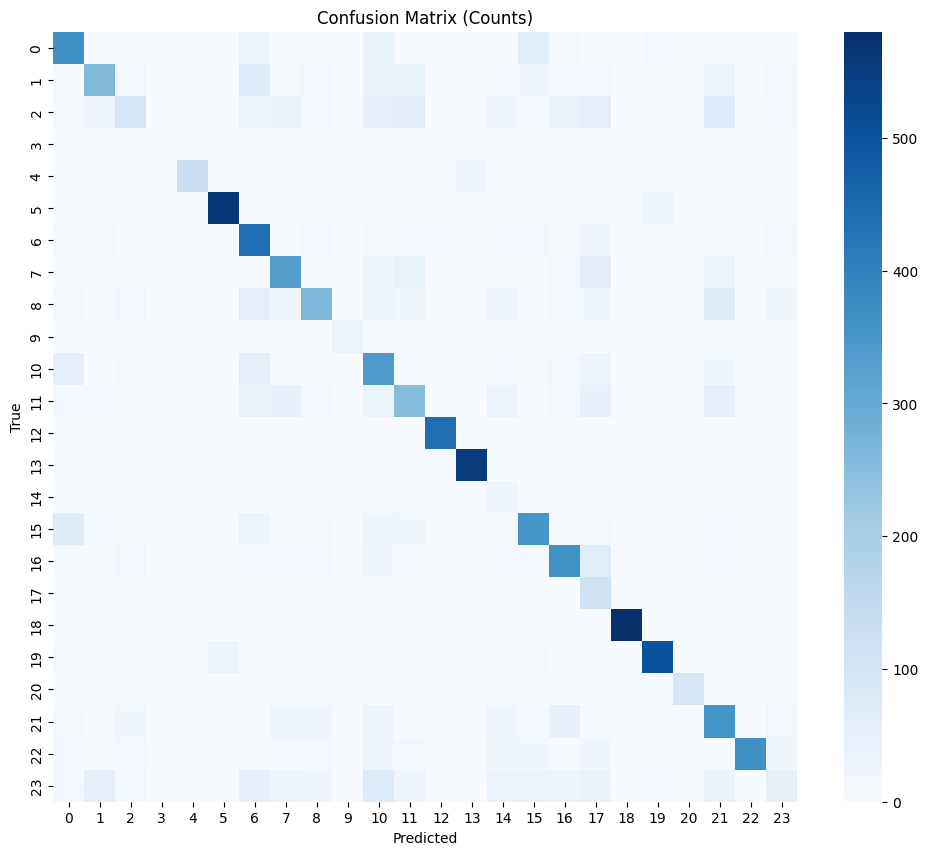

In [31]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred_proba = model.predict(X_test)
y_pred = np.argmax(y_pred_proba, axis=1)

print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, cmap='Blues', annot=False)
plt.title("Confusion Matrix (Counts)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


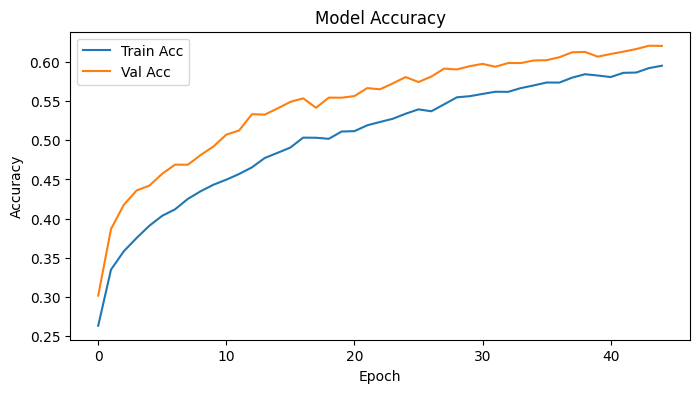

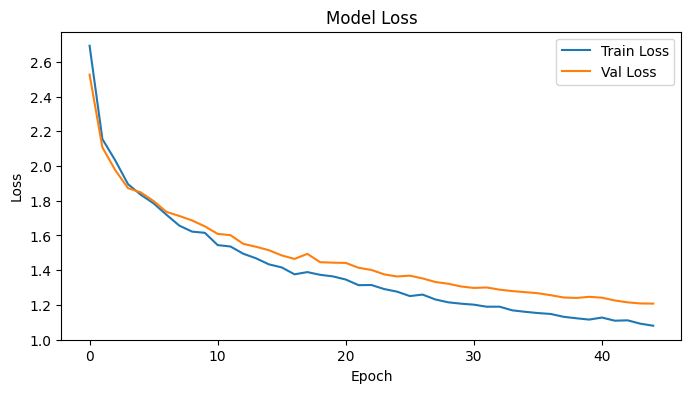

In [32]:
plt.figure(figsize=(8, 4))
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [33]:
model.save("mlp_multiclass_model.keras")
import joblib
joblib.dump(scaler, "scaler.pkl")
joblib.dump(le, "label_encoder.pkl")
print("Model, scaler, and encoder saved successfully!")


Model, scaler, and encoder saved successfully!


The MLP model achieved around 62% validation accuracy across 24 traffic categories using flow-level features.
With proper normalization, class balancing, and dropout regularization, the network showed smooth convergence without overfitting.
This demonstrates that a fully connected MLP can effectively capture static statistical characteristics of encrypted network flows — though sequential models (like LSTM) can further enhance accuracy by learning temporal dependencies.